In [180]:
import datetime
import glob
import matplotlib.pyplot as plt
from multiprocessing import Pool, Queue
import numpy as np
import os
import pickle
from subprocess import run, DEVNULL

from astropy.io import fits
from astropy.table import QTable
from astropy.wcs import WCS
import astropy.units as u

import sep

# Silence an annoying warning that pops up when using astrometry.net WCS FITS files
import logging
class SilenceFITSWarningFilter(logging.Filter):
    def filter(self, record):
        if 'The WCS transformation has more axes (2) than the image it is associated with (0)' in record.getMessage():
            return False
        return True
from astropy import log
log.addFilter(SilenceFITSWarningFilter())

%matplotlib widget

In [2]:
# read_path = '/media/evanmayer/TIMCAM-FTS25-IMG/'
read_path = '/media/shared/'
# read_path = '/home/evanmayer/TIM_data/test_events/TIMcam/flight_test/'

write_path = '/home/evanmayer/TIM_data/test_events/TIMcam/flight_test/solve/'

In [ ]:
# af_files = []
# af_files += sorted(glob.glob(os.path.join(write_path, '..', 'auto*2025-10-01_1[8-9]*.txt')))
# af_files += sorted(glob.glob(os.path.join(write_path, '..', 'auto*2025-10-01_2[0-3]*.txt')))
# af_files += sorted(glob.glob(os.path.join(write_path, '..', 'auto*2025-10-02_00*.txt')))
af_files = sorted(glob.glob(os.path.join(write_path, '..', 'auto*2025-10-0[1-2]*.txt')))

af_times = []
for file in af_files:
    b = os.path.splitext(os.path.basename(file))[0]
    parts = b.split('_')
    date, time = parts[-2:]
    af_times.append(datetime.datetime.fromisoformat(date + 'T' + time.replace('-', ':')))
[print(af_time) for af_time in af_times];

2025-10-01 11:00:33
2025-10-01 15:02:44
2025-10-01 19:04:55
2025-10-01 23:07:07
2025-10-02 03:09:17
2025-10-02 07:11:28
2025-10-02 11:13:39


[None, None, None, None, None, None, None]

In [3]:
s = np.s_[::1]
files = sorted(glob.glob(read_path + 'img/saved_image_2025-10-01_1[8-9]*.fz', recursive=True))
files += sorted(glob.glob(read_path + 'img/saved_image_2025-10-01_2[0-3]*.fz', recursive=True))
files += sorted(glob.glob(read_path + 'img/saved_image_2025-10-02_0[0-4]*.fz', recursive=True))
files = files[s]
if not isinstance(files, list):
    files = [files,]

print(len(files))
print(files)

raw_columns = ['FOCUSMIN', 'FOCUS', 'FOCUSMAX', 'GAINFACT', 'EXPTIME', 'UTC-SEC', 'UTC-USEC', 'CCDTEMP']
qty = {col: [] for col in raw_columns}

raw_units = [u.dimensionless_unscaled, u.dimensionless_unscaled, u.dimensionless_unscaled, u.dimensionless_unscaled, u.s, u.s, 1e-6 * u.s, u.deg_C]
unit_lookup = {col: unit for col, unit in zip(raw_columns, raw_units)}

27096
['/media/shared/img/saved_image_2025-10-01_18-00-01.fits.fz', '/media/shared/img/saved_image_2025-10-01_18-00-02.fits.fz', '/media/shared/img/saved_image_2025-10-01_18-00-04.fits.fz', '/media/shared/img/saved_image_2025-10-01_18-00-05.fits.fz', '/media/shared/img/saved_image_2025-10-01_18-00-07.fits.fz', '/media/shared/img/saved_image_2025-10-01_18-00-08.fits.fz', '/media/shared/img/saved_image_2025-10-01_18-00-10.fits.fz', '/media/shared/img/saved_image_2025-10-01_18-00-11.fits.fz', '/media/shared/img/saved_image_2025-10-01_18-00-13.fits.fz', '/media/shared/img/saved_image_2025-10-01_18-00-14.fits.fz', '/media/shared/img/saved_image_2025-10-01_18-00-16.fits.fz', '/media/shared/img/saved_image_2025-10-01_18-00-17.fits.fz', '/media/shared/img/saved_image_2025-10-01_18-00-19.fits.fz', '/media/shared/img/saved_image_2025-10-01_18-00-20.fits.fz', '/media/shared/img/saved_image_2025-10-01_18-00-22.fits.fz', '/media/shared/img/saved_image_2025-10-01_18-00-23.fits.fz', '/media/shared/im

Build the raw data table - only stuff found in headers

In [4]:
i = 0
n = len(files)
for file in files:
    i += 1
    print(f'progress: {100*i/n:.1f}%', end='\r')
    try:
        hdulist = fits.open(file, lazy_load_hdus=True)
        phdu, comphdu = hdulist
    except Exception as e:
        print(file, e)
        for key in raw_columns:
            qty[key].append(np.nan * unit_lookup[key])
        continue

    for key in raw_columns:
        qty[key].append(comphdu.header[key] * unit_lookup[key])

qty['FILES'] = files

img_table = QTable(qty)
try:
    img_table.write(read_path + 'tabulated.fits', overwrite=True)
except PermissionError as e:
    print(e, ', writing to local path', write_path)
img_table.write(write_path + 'tabulated.fits', overwrite=True)

# if overwriting results:
img_table_solved = img_table

# if updating on disk results:
# img_table_solved = QTable.read(write_path + 'tabulated_solved.fits')

[Errno 13] Permission denied: '/media/shared/tabulated.fits' , writing to local path /home/evanmayer/TIM_data/test_events/TIMcam/flight_test/solve/


Prepare to plate solve

In [5]:
fetch_size = lambda fname: os.lstat(fname).st_size
fetch_timestamp = lambda utc_sec, utc_usec: utc_sec + utc_usec

In [241]:
def solve_field(file, verbose=False):
    # Decompress file
    decomp_file = os.path.splitext(os.path.splitext(file)[0])[0] + '_funpack.fits'
    decomp_file = write_path + os.path.basename(decomp_file)
    if not os.path.exists(decomp_file):
        executable = 'funpack' # assumes astropy FITS tools in path
        options = [
            '-O', decomp_file, # specify output filename
        ]
        cmd = [executable,] + options + [file,]
        # print(cmd)
        # print(decomp_file)
        ret = run(cmd, stdout=DEVNULL)
        # ret.check_returncode()

    # Solve decompressed file
    executable = '/usr/local/astrometry/bin/solve-field'
    options = [
        '--dir=' + write_path,
        '--no-plots',
        # '--continue', # converse is '--overwrite'
        '--overwrite',
        # '--skip-solved',
        '--new-fits=none',
        '--parity=neg',
        '--code-tolerance=0.01',
        '--scale-low=6.7',
        '--scale-high=6.9',
        '--scale-units=arcsecperpix',
        '--use-source-extractor',
        '--objs=200',
        '--cpulimit=30',
    ]
    cmd = [executable, decomp_file] + options
    # print(cmd)
    if not verbose:
        ret = run(cmd, stderr=DEVNULL, stdout=DEVNULL)
    else:
        with open(write_path + 'solve_field_output.txt', 'w') as f:
            ret = run(cmd, stdout=f, stderr=f)
            print(ret.stdout, ret.stderr)
    # ret.check_returncode()

    # Look through astrometry.net output files
    solve_dir = write_path
    solved_file = solve_dir + os.path.splitext(os.path.basename(decomp_file))[0] + '.solved'

    if os.path.exists(solved_file):
        # get ra, dec, position angle
        wcs_file = os.path.splitext(solved_file)[0] + '.wcs'
        with fits.open(wcs_file) as f:
            h = f[0].header
        w = WCS(header=h)
        center = w.all_pix2world(h['IMAGEW'] / 2 + 0.5, h['IMAGEH'] / 2 + 0.5, 1)
        ra, dec = center[0], center[1]
        # https://github.com/dstndstn/astrometry.net/blob/039bafa8f1936735eb45213d7570ba03c3fa65e3/util/sip.c#L550
        det = w.wcs.cd[0, 0] * w.wcs.cd[1, 1] - w.wcs.cd[0, 1] * w.wcs.cd[1, 0]
        parity = (1 if det >= 0 else -1)
        T = parity * w.wcs.cd[0, 0] + w.wcs.cd[1, 1]
        A = parity * w.wcs.cd[1, 0] - w.wcs.cd[0, 1]
        orientation = -(np.atan2(A, T) * u.rad).to(u.deg).value

        # get plate scale
        # header = fits.open(wcs_file)[0].header
        for key, val in h.items():
            if 'COMMENT' not in key:
                continue
            if val.endswith('arcsec/pix'):
                scale = float(val.split(' ')[1])

        # calculate RMSE
        corr_file = os.path.splitext(solved_file)[0] + '.corr'
        tbl = fits.open(corr_file)[1].data
        rmse = scale * np.sqrt(np.mean((tbl.index_x - tbl.field_x)**2 + (tbl.index_y - tbl.field_y)**2))
        n_stars_matched = len(tbl.field_x)
        solved = 1
    else:
        ra = np.nan
        dec = np.nan
        orientation = np.nan
        scale = np.nan
        n_stars_found = np.nan
        n_stars_matched = np.nan
        rmse = np.nan
        solved = 0

    # axy file contains blobs sent to solver
    axy_file = os.path.splitext(solved_file)[0] + '.axy'
    tbl = fits.open(axy_file)[1].data
    try:
        n_stars_found = len(tbl.X) # default
    except AttributeError as e:
        n_stars_found = len(tbl.X_IMAGE) # source extractor

    # clean up
    os.remove(decomp_file)

    return ra, dec, orientation, scale, n_stars_found, n_stars_matched, rmse, solved

In [242]:
# solve_field('/media/shared/img/saved_image_2025-10-02_02-00-58.fits.fz', verbose=True)
# hdulist = fits.open('/media/shared/img/saved_image_2025-10-02_02-00-58.fits.fz', lazy_load_hdus=True)
# _, comphdu = hdulist
# bkg = sep.Background(np.astype(comphdu.data, float))
# bkg_image = bkg.back()
# srcs = comphdu.data - bkg_image

# plt.close('all')
# fig, ax = plt.subplots(figsize=(12,5), ncols=2)
# # ax[0].imshow(bkg_image)
# m, s = srcs.mean(), srcs.std()
# ax[1].imshow(srcs, vmin=m-s, vmax=m+s)
# res = sep.extract(srcs, 3, err=4)
# print(len(res))
# ax[1].scatter(res['x'], res['y'], facecolor='none', edgecolor='w')

In [ ]:
def background_adu(file, plot=False):
    hdulist = fits.open(file, lazy_load_hdus=True)
    _, comphdu = hdulist
    bkg = sep.Background(np.astype(comphdu.data, float))
    bkg_image = bkg.back()

    if plot:
        fig, ax = plt.subplots()
        ax.imshow(bkg_image)

    return bkg.globalback

In [8]:
derived_columns = ['SOLVE_ATTEMPTED', 'SOLVED', 'FILESIZE', 'TIMESTAMP', 'RA', 'DEC', 'ORIENTATION', 'SCALE', 'N_STARS_FOUND', 'N_STARS_MATCHED', 'RMSE', 'BKG_MED', 'BKG_MEAN']
derived_units = [u.dimensionless_unscaled, u.dimensionless_unscaled, u.dimensionless_unscaled, u.s, u.deg, u.deg, u.deg, u.arcsec / u.pix, u.dimensionless_unscaled, u.dimensionless_unscaled, u.arcsec, u.dimensionless_unscaled, u.dimensionless_unscaled]
unit_lookup.update({col: unit for col, unit in zip(derived_columns, derived_units)})

for col in derived_columns:
    img_table_solved[col] = np.ones_like(img_table_solved['FOCUS']).value * np.nan * unit_lookup[col]

n_prog = len(img_table_solved)
solution_progress = Queue()

In [25]:
def solve_table_row(i):
    if img_table_solved['SOLVE_ATTEMPTED'][i] == 1:
        print('Skipping row, already attempted')
        return
    file = img_table_solved['FILES'][i]
    size = fetch_size(file)
    timestamp = fetch_timestamp(img_table_solved['UTC-SEC'][i], img_table_solved['UTC-USEC'][i])

    ra, dec, orientation, scale, n_stars_found, n_stars_matched, rmse, solved = solve_field(file)

    # print(ra, dec, orientation, scale, n_stars_found, n_stars_matched, rmse, solved)
    solution_packet = {
        'SOLVE_ATTEMPTED': 1,
        'FILES': file,
        'FILESIZE': size,
        'TIMESTAMP': timestamp.value,
        'RA': ra,
        'DEC': dec,
        'ORIENTATION': orientation,
        'SCALE': scale,
        'N_STARS_FOUND': n_stars_found,
        'N_STARS_MATCHED': n_stars_matched,
        'RMSE': rmse,
        'SOLVED': solved
    }
    pickle_back = write_path + os.path.splitext(os.path.splitext(os.path.basename(file))[0])[0] + '_sol.pickle'
    with open(pickle_back, 'wb') as f:
        pickle.dump(solution_packet, f)

    solution_progress.put(1)

    print(f'{file} {"SOLVED" if solved else "NOT SOLVED"} [{100 * solution_progress.qsize() / n_prog:.6f}%, {solution_progress.qsize()} / {n_prog}]', end='\r')
    return solution_packet


def sep_table_row(i):
    file = img_table_solved['FILES'][i]
    bkg_adu = background_adu(file)
    solution_packet = {
        'FILES': file,
        'BKG_MEAN': bkg_adu
    }
    pickle_back = write_path + os.path.splitext(os.path.splitext(os.path.basename(file))[0])[0] + '_back.pickle'
    with open(pickle_back, 'wb') as f:
        pickle.dump(solution_packet, f)

    solution_progress.put(1)
    
    print(f'{file} done. [{100 * solution_progress.qsize() / n_prog:.6f}%, {solution_progress.qsize()} / {n_prog}]', end='\r')
    return solution_packet

In [26]:
# parallelize plate solving
solution_progress = Queue()
with Pool(processes=7) as pool:
    a_res = pool.map_async(solve_table_row, range(len(img_table_solved)))
    res = a_res.get()

KeyboardInterrupt: 

In [27]:
# a method involving pickled results, in case the above Pool never finishes
res = []
for file in glob.glob(write_path + '*_sol.pickle'):
    with open(file, 'rb') as f:
        res.append(pickle.load(f))

# unwind plate solving results
for j, result in enumerate(res):
    print(f'{j / len(res):.3f}', end='\r')
    match = (img_table_solved['FILES'] == result['FILES'])
    i = np.where(match)[0][0]
    for key, val in result.items():
        # print(i, key, val)
        if 'FILES' == key:
            img_table_solved[i][key] = val
        else:
            img_table_solved[i][key] = val * unit_lookup[key]

In [10]:
# parallelize background estimation
solution_progress = Queue()
with Pool(processes=7) as pool:
    a_res = pool.map_async(sep_table_row, range(len(img_table_solved)))
    res = a_res.get()

In [14]:
# a method involving pickled results, in case the above Pool never finishes
res = []
for file in glob.glob(write_path + '*_back.pickle'):
    with open(file, 'rb') as f:
        res.append(pickle.load(f))

# unwind sep results
for j, result in enumerate(res):
    print(f'{j / len(res):.3f}', end='\r')
    match = (img_table_solved['FILES'] == result['FILES'])
    i = np.where(match)[0][0]
    for key, val in result.items():
        if 'FILES' == key:
            img_table_solved[i][key] = val
        else:
            img_table_solved[i][key] = val * unit_lookup[key]

In [28]:
img_table_solved.write(write_path + 'tabulated_solved.fits', overwrite=True)
# img_table_solved = QTable.read(write_path + 'tabulated_solved.fits')

In [29]:
t = []
t_not_nans = []
for i in range(len(img_table_solved)):
    if ~np.isnan(img_table_solved['TIMESTAMP'][i]):
        t.append(
            datetime.datetime.fromtimestamp(
                img_table_solved['TIMESTAMP'][i].value,
                datetime.timezone(datetime.timedelta(hours=0))
            )
        )
        t_not_nans.append(True)
    else:
        t.append(np.nan)
        t_not_nans.append(False)
t = np.array(t)

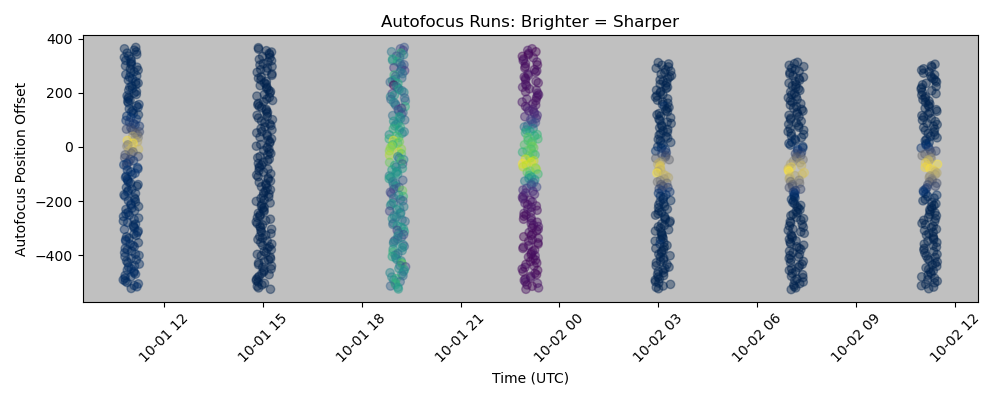

In [179]:
fig, ax = plt.subplots(figsize=(10,4))
daytime_start = datetime.datetime.fromisoformat('2025-10-01T16:00:00')
daytime_end = datetime.datetime.fromisoformat('2025-10-02T01:00:00')
for i, af_file in enumerate(af_files):
    sharpness, focus_pos = np.genfromtxt(af_file, unpack=True)
    # print(sharpness, focus_pos)
    judder = np.array([datetime.timedelta(hours=hr) for hr in np.random.uniform(-.25, .25, size=len(focus_pos))]) 
    # print('judder', judder)
    if daytime_start < af_times[i] < daytime_end:
        cmap = 'viridis'
    else:
        cmap = 'cividis'
    ax.scatter(np.array([af_times[i],] * len(focus_pos)) + judder, focus_pos, c=sharpness, cmap=cmap, alpha=0.4)
ax.xaxis.set_tick_params(rotation=45)
ax.set_facecolor('silver')
ax.set_xlabel('Time (UTC)')
ax.set_ylabel('Autofocus Position Offset')
ax.set_title('Autofocus Runs: Brighter = Sharper')
fig.tight_layout()

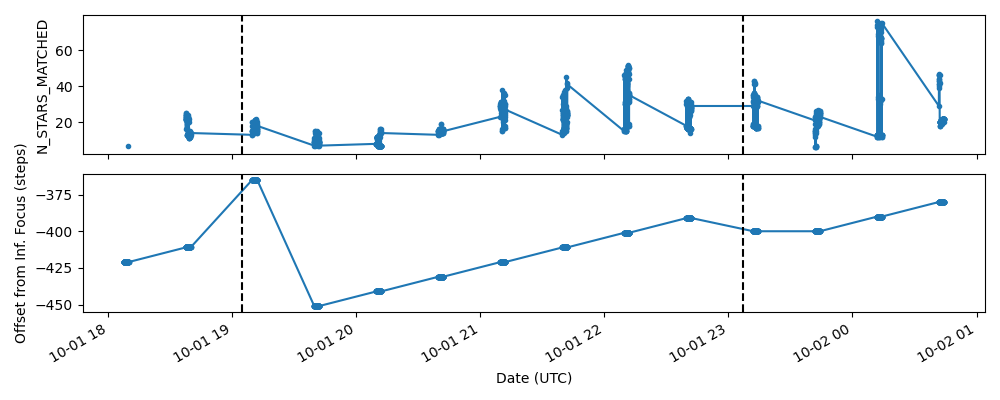

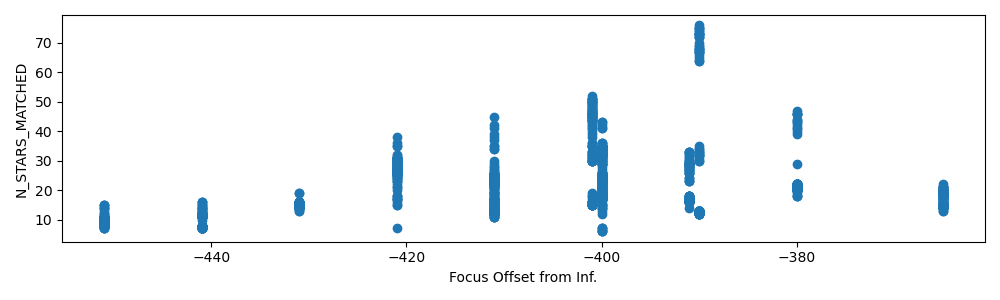

In [137]:
default_gain = (abs(img_table_solved['GAINFACT'] - 1.0) < 1e-3)
default_exp = (abs(img_table_solved['EXPTIME'] - 0.1 * u.s) < 1e-3 * u.s)
daytime_float = []
for fname in img_table_solved['FILES']:
    if (
        ('10-01_18' in fname)
        or ('10-01_19' in fname)
        or ('10-01_20' in fname)
        or ('10-01_21' in fname)
        or ('10-01_22' in fname)
        or ('10-01_23' in fname)
        or ('10-02_00' in fname)
    ):
        daytime_float.append(True)
        # print(fname)
    else:
        daytime_float.append(False)
daytime_float = np.array(daytime_float)
# [print(file) for file in img_table_solved[default_gain & default_exp & daytime_float]['FILES']];

fig, ax = plt.subplots(figsize=(10,4), nrows=2, sharex=True)
ax[0].plot(
    # img_table_solved[default_gain & default_exp & daytime_float]['TIMESTAMP'],
    t[t_not_nans & default_gain & default_exp & daytime_float],
    img_table_solved[t_not_nans & default_gain & default_exp & daytime_float]['N_STARS_MATCHED'],
    marker='.'
)
[ax[0].axvline(af_time, color='k', linestyle='--') for af_time in af_times]
ax[0].set_ylabel('N_STARS_MATCHED')

ax[1].plot(
    # img_table_solved[default_gain & default_exp & daytime_float]['TIMESTAMP'],
    t[t_not_nans & default_gain & default_exp & daytime_float],
    img_table_solved[t_not_nans & default_gain & default_exp & daytime_float]['FOCUS'] - img_table_solved[t_not_nans & default_gain & default_exp & daytime_float]['FOCUSMAX'],
    marker='.'
)
[ax[1].axvline(af_time, color='k', linestyle='--') for af_time in af_times]
ax[1].set_ylabel('Offset from Inf. Focus (steps)')
ax[1].set_xlabel('Date (UTC)')
fig.autofmt_xdate()
fig.tight_layout()

fig, ax = plt.subplots(figsize=(10,3))
ax.scatter(
    img_table_solved[t_not_nans & default_gain & default_exp & daytime_float]['FOCUS'] - img_table_solved[t_not_nans & default_gain & default_exp & daytime_float]['FOCUSMAX'],
    img_table_solved[t_not_nans & default_gain & default_exp & daytime_float]['N_STARS_MATCHED'],
)
ax.set_xlabel('Focus Offset from Inf.')
ax.set_ylabel('N_STARS_MATCHED')
fig.tight_layout()

1 0.05 s [1. 1. 1. ... 1. 1. 1.] [0.04999641 0.04999641 0.04999641 ... 0.04999641 0.04999641 0.04999641] s
2 0.05 s [2. 2. 2. ... 2. 2. 2.] [0.04999641 0.04999641 0.04999641 ... 0.04999641 0.04999641 0.04999641] s
3 0.05 s [3. 3. 3. ... 3. 3. 3.] [0.04999641 0.04999641 0.04999641 ... 0.04999641 0.04999641 0.04999641] s
4 0.05 s [4. 4. 4. ... 4. 4. 4.] [0.04999641 0.04999641 0.04999641 ... 0.04999641 0.04999641 0.04999641] s
1 0.1 s [1. 1. 1. ... 1. 1. 1.] [0.1000048 0.1000048 0.1000048 ... 0.1000048 0.1000048 0.1000048] s
2 0.1 s [2. 2. 2. ... 2. 2. 2.] [0.1000048 0.1000048 0.1000048 ... 0.1000048 0.1000048 0.1000048] s
3 0.1 s [3. 3. 3. ... 3. 3. 3.] [0.1000048 0.1000048 0.1000048 ... 0.1000048 0.1000048 0.1000048] s
4 0.1 s [4. 4. 4. ... 4. 4. 4.] [0.1000048 0.1000048 0.1000048 ... 0.1000048 0.1000048 0.1000048] s
1 0.2 s [1. 1. 1. ... 1. 1. 1.] [0.2000071 0.2000071 0.2000071 ... 0.2000071 0.2000071 0.2000071] s
2 0.2 s [2. 2. 2. ... 2. 2. 2.] [0.2000071 0.2000071 0.2000071 ... 0.200

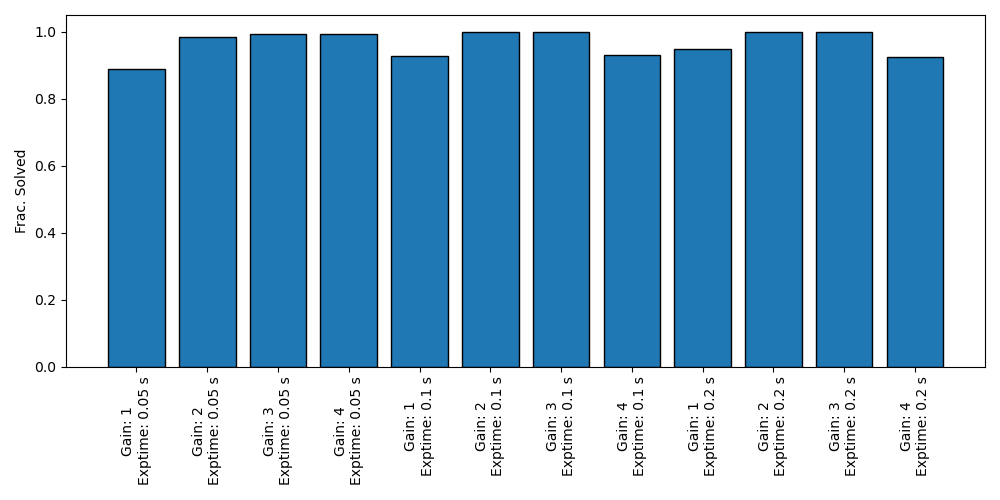

In [35]:
fig, ax = plt.subplots(figsize=(10,5))

float_time = datetime.datetime.fromisoformat('2025-10-01T19:00:00.0000Z').timestamp() * u.s
daytime_end = float_time + 8 * u.hr

tol = 1e-3
i = 0
labels = []
for exptime in np.array([0.05, 0.1, 0.2]) * u.s:
    for gain in range(1,5):
        pop = (
            daytime_float &
            (abs(img_table_solved['GAINFACT'] - gain) < tol) &
            (abs(img_table_solved['EXPTIME'] - exptime) < (tol * exptime.unit))
        )
        print(gain, exptime, img_table_solved['GAINFACT'][pop], img_table_solved['EXPTIME'][pop])
        ax.bar(i, np.nansum(img_table_solved['SOLVED'][pop]) / np.nansum(img_table_solved['SOLVE_ATTEMPTED'][pop]), color='C0', edgecolor='k')
        i += 1
        labels.append(f'Gain: {gain}\nExptime: {exptime}')
ax.set_ylabel('Frac. Solved')
ax.set_xticks(range(i))
ax.set_xticklabels(labels, rotation=90)
fig.tight_layout()

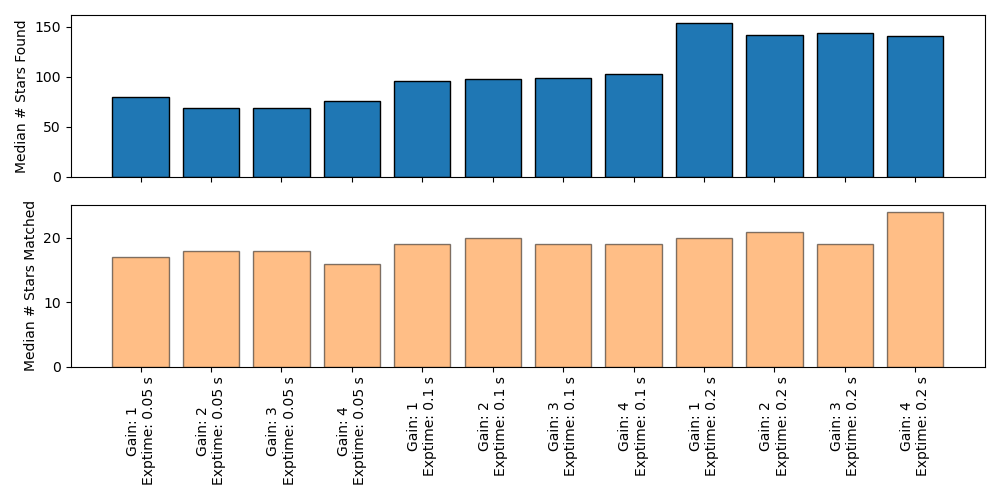

In [36]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)

tol = 1e-3
i = 0
labels = []
for exptime in np.array([0.05, 0.1, 0.2]) * u.s:
    for gain in range(1,5):
        pop = (
            daytime_float &
            (abs(img_table_solved['GAINFACT'] - gain) < tol) &
            (abs(img_table_solved['EXPTIME'] - exptime) < (tol * exptime.unit))
        )
        # print(gain, exptime, img_table_solved['GAINFACT'][pop], img_table_solved['EXPTIME'][pop])
        ax[0].bar(i, np.nanmedian(img_table_solved['N_STARS_FOUND'][pop]), edgecolor='k', facecolor='C0')
        ax[1].bar(i, np.nanmedian(img_table_solved['N_STARS_MATCHED'][pop]), edgecolor='k', facecolor='C1', alpha=0.5)
        i += 1
        labels.append(f'Gain: {gain}\nExptime: {exptime}')
ax[0].set_ylabel('Median # Stars Found')
ax[1].set_ylabel('Median # Stars Matched')
ax[1].set_xticks(range(i))
ax[1].set_xticklabels(labels, rotation=90)
fig.tight_layout()

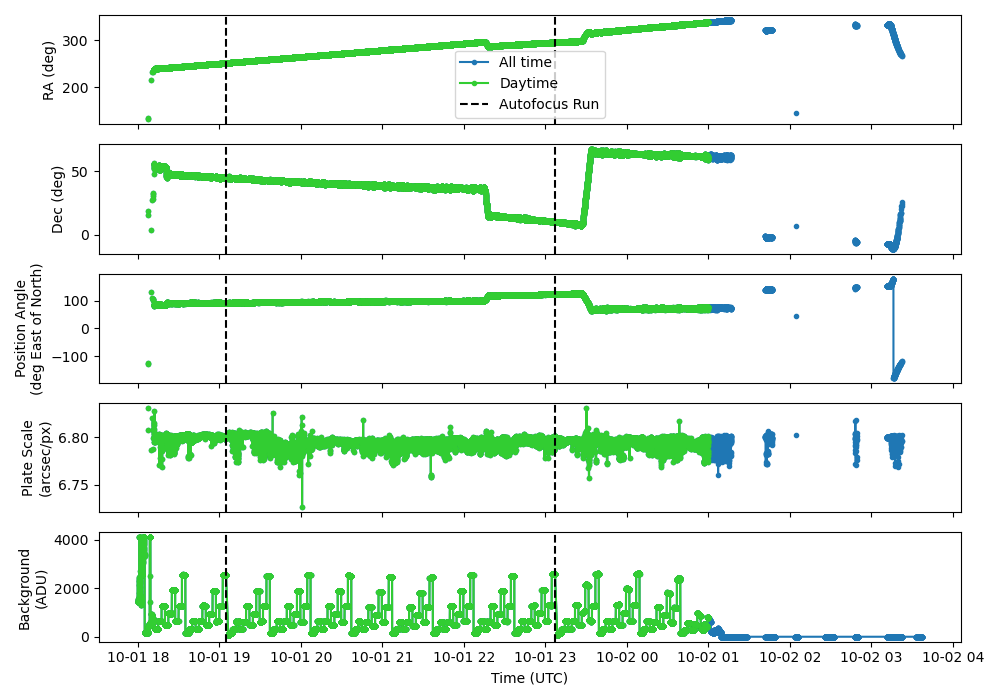

In [133]:
fig, ax = plt.subplots(figsize=(10,7), nrows=5, sharex=True)
ax[0].plot(t[t_not_nans], img_table_solved['RA'][t_not_nans], marker='.')
ax[0].plot(t[t_not_nans & daytime_float], img_table_solved['RA'][t_not_nans & daytime_float], marker='.', color='limegreen')
[ax[0].axvline(af_time, color='k', linestyle='--') for af_time in af_times]
ax[0].legend(['All time', 'Daytime', 'Autofocus Run'])
ax[0].set_ylabel('RA (deg)')

ax[1].plot(t[t_not_nans], img_table_solved['DEC'][t_not_nans], marker='.')
ax[1].plot(t[t_not_nans & daytime_float], img_table_solved['DEC'][t_not_nans & daytime_float], marker='.', color='limegreen')
[ax[1].axvline(af_time, color='k', linestyle='--') for af_time in af_times]
ax[1].set_ylabel('Dec (deg)')

ax[2].plot(t[t_not_nans], img_table_solved['ORIENTATION'][t_not_nans], marker='.')
ax[2].plot(t[t_not_nans & daytime_float], img_table_solved['ORIENTATION'][t_not_nans & daytime_float], marker='.', color='limegreen')
[ax[2].axvline(af_time, color='k', linestyle='--') for af_time in af_times]
ax[2].set_ylabel('Position Angle\n(deg East of North)')

ax[3].plot(t[t_not_nans], img_table_solved['SCALE'][t_not_nans], marker='.')
ax[3].plot(t[t_not_nans & daytime_float], img_table_solved['SCALE'][t_not_nans & daytime_float], marker='.', color='limegreen')
[ax[3].axvline(af_time, color='k', linestyle='--') for af_time in af_times]
ax[3].set_ylabel('Plate Scale\n(arcsec/px)')

ax[4].plot(t[t_not_nans], img_table_solved['BKG_MEAN'][t_not_nans], marker='.')
ax[4].plot(t[t_not_nans & daytime_float], img_table_solved['BKG_MEAN'][t_not_nans & daytime_float], marker='.', color='limegreen')
[ax[4].axvline(af_time, color='k', linestyle='--') for af_time in af_times]
ax[4].set_ylabel('Background\n(ADU)')
ax[4].set_xlabel('Time (UTC)')

fig.tight_layout()

Text(0, 0.5, 'Background (ADU)')

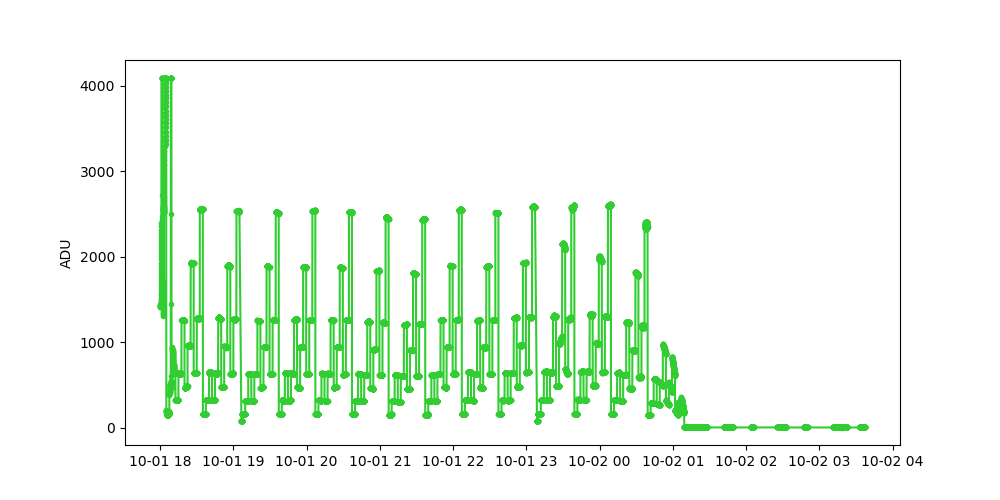

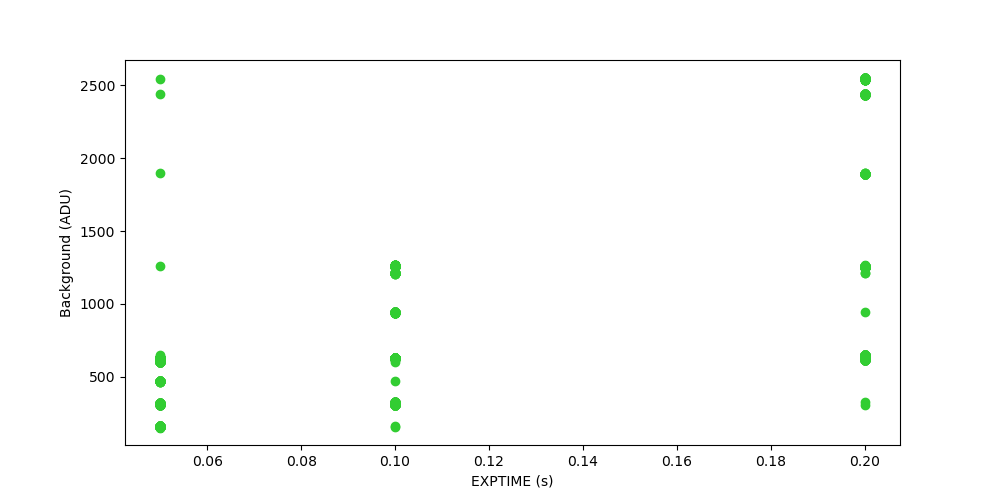

In [76]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(t[t_not_nans], img_table_solved['BKG_MEAN'][t_not_nans], marker='.', color='limegreen')
ax.set_ylabel('ADU')

fig, ax = plt.subplots(figsize=(10,5))
# ax.scatter(img_table_solved['EXPTIME'], img_table_solved['BKG_MEAN'])
e = img_table_solved['EXPTIME'][daytime_float]
b = img_table_solved['BKG_MEAN'][daytime_float]
ax.scatter(
    e[len(e)//2:len(e)//2 + 2000],
    b[len(e)//2:len(e)//2 + 2000],
    color='limegreen'
)
ax.set_xlabel('EXPTIME (s)')
ax.set_ylabel('Background (ADU)')
# ax.set_yscale('log')

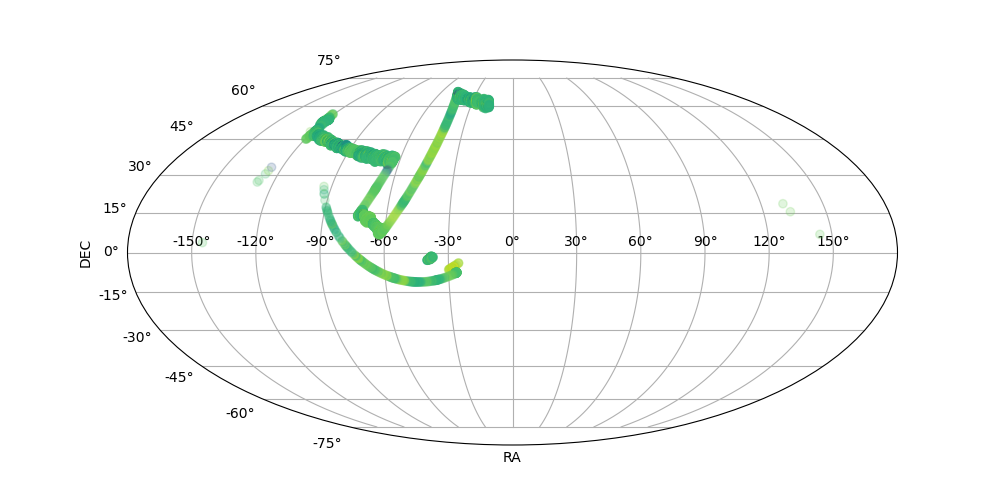

In [39]:
fig, ax = plt.subplots(figsize=(10,5), subplot_kw=dict(projection='mollweide'))
not_nans = ~np.isnan(img_table_solved['RA'])
ra = img_table_solved['RA'][not_nans].to(u.rad)
dec = img_table_solved['DEC'][not_nans].to(u.rad),
ra[ra > np.pi * u.rad] -= 2 * np.pi * u.rad
ax.scatter(
    ra,
    dec,
    c=np.log10(img_table_solved['RMSE'][not_nans].value),
    alpha=0.2
)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.grid()
ax.set_axisbelow(True)

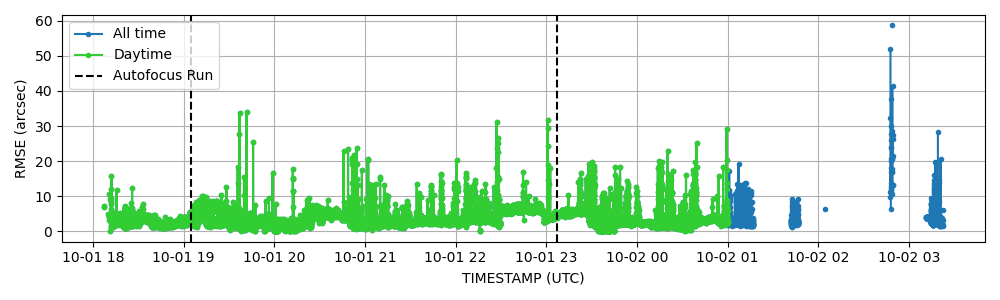

In [132]:
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(t[t_not_nans], img_table_solved['RMSE'][t_not_nans], marker='.')
ax.plot(t[t_not_nans & daytime_float], img_table_solved['RMSE'][t_not_nans & daytime_float], marker='.', color='limegreen')
[ax.axvline(af_time, color='k', linestyle='--') for af_time in af_times]
ax.set_xlabel('TIMESTAMP (UTC)')
ax.set_ylabel('RMSE (arcsec)')
ax.grid()
ax.legend(['All time', 'Daytime', 'Autofocus Run'])
fig.tight_layout()

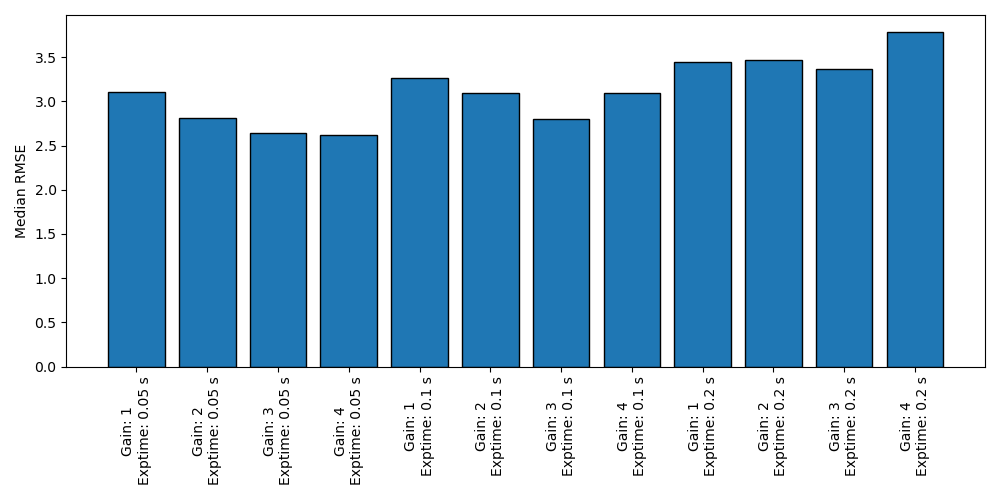

In [135]:
fig, ax = plt.subplots(figsize=(10,5))

tol = 1e-3
i = 0
labels = []
for exptime in np.array([0.05, 0.1, 0.2]) * u.s:
    for gain in range(1,5):
        pop = (
            daytime_float &
            (abs(img_table_solved['GAINFACT'] - gain) < tol) &
            (abs(img_table_solved['EXPTIME'] - exptime) < (tol * exptime.unit))
        )
        ax.bar(i, np.nanmedian(img_table_solved['RMSE'][pop]), color='C0', edgecolor='k')
        i += 1
        labels.append(f'Gain: {gain}\nExptime: {exptime}')
ax.set_ylabel('Median RMSE')
ax.set_xticks(range(i))
ax.set_xticklabels(labels, rotation=90)
fig.tight_layout()

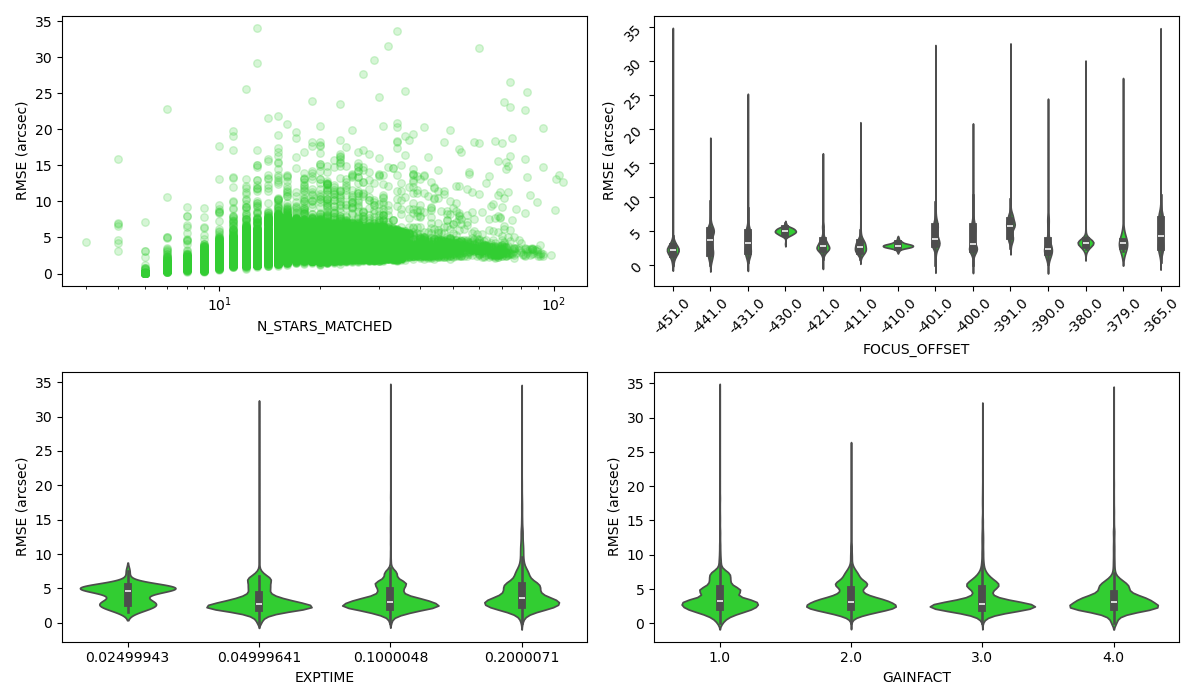

In [108]:
import seaborn as sns


df = img_table_solved.to_pandas()

fig, ax = plt.subplots(figsize=(12,7), nrows=2, ncols=2)
ax[0][0].scatter(img_table_solved['N_STARS_MATCHED'][daytime_float], img_table_solved['RMSE'][daytime_float], s=30, alpha=0.2, color='limegreen')
ax[0][0].set_xlabel('N_STARS_MATCHED')
ax[0][0].set_ylabel('RMSE (arcsec)')
ax[0][0].set_xscale('log')

# fig, ax = plt.subplots()
sns.violinplot(x=df['EXPTIME'][daytime_float], y=df['RMSE'][daytime_float], ax=ax[1][0], facecolor='limegreen')
ax[1][0].set_xlabel('EXPTIME')
ax[1][0].set_ylabel('RMSE (arcsec)')

# fig, ax = plt.subplots()
sns.violinplot(x=df['GAINFACT'][daytime_float], y=df['RMSE'][daytime_float], ax=ax[1][1], facecolor='limegreen')
ax[1][1].set_xlabel('GAINFACT')
ax[1][1].set_ylabel('RMSE (arcsec)')

# fig, ax = plt.subplots()
sns.violinplot(x=df['FOCUS'][daytime_float] - df['FOCUSMAX'][daytime_float], y=df['RMSE'][daytime_float], ax=ax[0][1], facecolor='limegreen')
ax[0][1].set_xlabel('FOCUS_OFFSET')
ax[0][1].set_ylabel('RMSE (arcsec)')
ax[0][1].tick_params(rotation=45)

fig.tight_layout()

In [134]:
pct_float_solved = 100 * np.nansum(img_table_solved['SOLVED'][daytime_float]) / np.nansum(img_table_solved['SOLVE_ATTEMPTED'][daytime_float])
pct_float_solved

<Quantity 96.57637095>